In this Jupyter notebook we explore different compounds that have been tested in assays for interaction with β-amyloid protein and review ML algorithms predicting bioactivity values based on molecule fingerprints.

The β-amyloid protein (β/A4), derived from a larger amyloid precursor protein (APP), is a polypeptide, whose amyloid fibrillar form is the primary component of amyloid plaques found in the brains of Alzheimer's disease patients. [[1]](https://www.science.org/doi/10.1126/science.1691865#:~:text=The%20%CE%B2%2Damyloid%20protein%20(%CE%B2,a%20carboxyl%2Dterminal%20truncated%20molecule.) [[2]](https://en.wikipedia.org/wiki/Amyloid-beta_precursor_protein)

1. Query data from ChEMBL Database
2. Data Preprocessing
    - Data cleaning, normalization
    - Add Bioactivity Class
    - Add Lipinski descriptors
3. EDA
    - Visualizations
    - Mann-Whitney U Test
4. Calculate molecular fingerprints
5. ML part
    - Prepare dataset
    - Random Forest for bioactivity prediction
    - Different ML algorithms from LazyRegressor for bioactivity prediction
    
Jupyter notebook following the youtube series by [DataProfessor](https://www.youtube.com/c/DataProfessor)

In [1]:
from typing import List, Optional

import numpy as np
from numpy.random import seed
from numpy.random import randn

from IPython.display import display

import pandas as pd

from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from padelpy import padeldescriptor

from scipy.stats import mannwhitneyu
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from lazypredict.Supervised import LazyRegressor

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set(style="ticks")

In [3]:
IC50_MAX_VALUE = 100_000_000
SEED = 1

DATAFRAME_COLUMNS_FILTER = [
    "activity_id", "molecule_chembl_id", "canonical_smiles", "standard_value"]

DESCRIPTOR_FUNCTIONS = {
    "MW": Descriptors.MolWt,
    "LogP": Descriptors.MolLogP,
    "NumHDonors": Lipinski.NumHDonors,
    "NumHAcceptors": Lipinski.NumHAcceptors
}
DEFAULT_DESCRIPTORS = list(DESCRIPTOR_FUNCTIONS.keys())

MANN_WHITNEY_DESCRIPTORS = ["pIC50", "MW", "LogP", "NumHDonors", "NumHAcceptors"]

## 1. Query Bioactivity Data From ChEMBL Database

The ChEMBL Dataset - is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity, and genomic data to aid the translation of genomic information into effective new drugs.

In [4]:
target_search_result = new_client.target.search("Alzheimer")
targets = pd.DataFrame.from_dict(target_search_result)

In [5]:
print(targets.shape)
targets

(6, 9)


,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,Nucleosome-remodeling factor subunit BPTF,13.00,False,CHEMBL3085621,"[{'accession': 'Q12830', 'component_descriptio...",SINGLE PROTEIN,9606
1,"[{'xref_id': 'Q92542', 'xref_name': None, 'xre...",Homo sapiens,Nicastrin,11.00,False,CHEMBL3418,"[{'accession': 'Q92542', 'component_descriptio...",SINGLE PROTEIN,9606
2,[],Homo sapiens,Gamma-secretase,11.00,False,CHEMBL2094135,"[{'accession': 'Q96BI3', 'component_descriptio...",PROTEIN COMPLEX,9606
3,[],Rattus norvegicus,Amyloid beta A4 protein,9.00,False,CHEMBL3638365,"[{'accession': 'P08592', 'component_descriptio...",SINGLE PROTEIN,10116
4,[],Mus musculus,Amyloid-beta A4 protein,8.00,False,CHEMBL4523942,"[{'accession': 'P12023', 'component_descriptio...",SINGLE PROTEIN,10090
5,"[{'xref_id': 'P05067', 'xref_name': None, 'xre...",Homo sapiens,Beta amyloid A4 protein,7.00,False,CHEMBL2487,"[{'accession': 'P05067', 'component_descriptio...",SINGLE PROTEIN,9606


In [6]:
target_filter_fields = ["organism", "pref_name", "target_type",
                                    "target_chembl_id", "score"]
selected_target = targets.iloc[5][target_filter_fields]
selected_target

organism                       Homo sapiens
pref_name           Beta amyloid A4 protein
target_type                  SINGLE PROTEIN
target_chembl_id                 CHEMBL2487
score                                  7.00
Name: 5, dtype: object

In [7]:
target_chembl_id = selected_target["target_chembl_id"]
target_chembl_id

'CHEMBL2487'

In [8]:
activity_search_result = new_client.activity.filter(target_chembl_id=target_chembl_id).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(activity_search_result)

In [9]:
print(df.shape)
df.head(5)

(1567, 46)


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,357577,[],CHEMBL678443,Inhibition of A-beta-42 production by inhibiti...,B,None,None,BAO_0000190,...,Homo sapiens,Beta amyloid A4 protein,9606,None,None,IC50,uM,UO_0000065,None,5.0
1,None,None,357580,[],CHEMBL678443,Inhibition of A-beta-42 production by inhibiti...,B,None,None,BAO_0000190,...,Homo sapiens,Beta amyloid A4 protein,9606,None,None,IC50,uM,UO_0000065,None,2.7
2,None,None,358965,[],CHEMBL678443,Inhibition of A-beta-42 production by inhibiti...,B,None,None,BAO_0000190,...,Homo sapiens,Beta amyloid A4 protein,9606,None,None,IC50,uM,UO_0000065,None,1.8
3,None,None,368887,[],CHEMBL678443,Inhibition of A-beta-42 production by inhibiti...,B,None,None,BAO_0000190,...,Homo sapiens,Beta amyloid A4 protein,9606,None,None,IC50,uM,UO_0000065,None,11.0
4,None,None,375954,[],CHEMBL678443,Inhibition of A-beta-42 production by inhibiti...,B,None,None,BAO_0000190,...,Homo sapiens,Beta amyloid A4 protein,9606,None,None,IC50,uM,UO_0000065,None,10.0


In [10]:
print(df.columns.tolist())

['action_type', 'activity_comment', 'activity_id', 'activity_properties', 'assay_chembl_id', 'assay_description', 'assay_type', 'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint', 'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment', 'data_validity_description', 'document_chembl_id', 'document_journal', 'document_year', 'ligand_efficiency', 'molecule_chembl_id', 'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id', 'standard_flag', 'standard_relation', 'standard_text_value', 'standard_type', 'standard_units', 'standard_upper_value', 'standard_value', 'target_chembl_id', 'target_organism', 'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type', 'units', 'uo_units', 'upper_value', 'value']


In [11]:
df.to_csv("original_bioactivity_data.csv", index=False)

## 2. Data Preprocessing

### 2.1 Initial Preprocessing

**IC50**

The half maximal inhibitory concentration (IC50) is a **measure of the potency of a substance in inhibiting a specific biological or biochemical function**. IC50 is a quantitative measure that indicates how much of a particular inhibitory substance (e.g. drug) is needed to inhibit, in vitro, a given biological process or biological component by 50%. The biological component could be an enzyme, cell, cell receptor or microorganism. IC50 values are typically expressed as molar concentration. [[3]](https://en.wikipedia.org/wiki/IC50#:~:text=IC50%20is%20a%20quantitative,cell%2C%20cell%20receptor%20or%20microorganism.)

In [12]:
df["standard_type"].unique()

array(['IC50'], dtype=object)

In [13]:
df["standard_value"] = df["standard_value"].astype(float)

In [14]:
df["standard_value"].describe()

count     1393.00
mean     20087.91
std      52580.44
min         -5.00
25%        250.00
50%       4800.00
75%      16800.00
max     800000.00
Name: standard_value, dtype: float64

In [15]:
# remove nans, negative IC50 values
df = df[df["standard_value"].notna()]
df = df[df["standard_value"] >= 0]

In [16]:
# remove unused fields
df = df[DATAFRAME_COLUMNS_FILTER]
df = df.reset_index(drop=True)

In [17]:
print(df.shape)
df.head(5)

(1391, 4)


,activity_id,molecule_chembl_id,canonical_smiles,standard_value
0,357577,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5000.00
1,357580,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,2700.00
2,358965,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,1800.00
3,368887,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,11000.00
4,375954,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,10000.00


### 2.2 Add Bioactivity Class

In [18]:
# active: values <= 1,000 nM
# intermediate: 1,000 nM < values < 10,000 nM
# inactive: values >= 10,000 nM

def add_bioactivity_class(df: pd.DataFrame, remove_intermediate: bool = True
                          ) -> pd.DataFrame:
    bioactivity_class = []
    for value in df["standard_value"]:
        if value >= 10000:
            bioactivity_class.append("inactive")
        elif value <= 1000:
            bioactivity_class.append("active")
        else:
            bioactivity_class.append("intermediate")
    
    df["bioactivity_class"] = bioactivity_class
    
    if remove_intermediate:
        df = df[df.bioactivity_class != "intermediate"]

    return df.reset_index(drop=True)

In [19]:
df = add_bioactivity_class(df, remove_intermediate=False)

In [20]:
print(df.shape)
df.head(5)

(1391, 5)


,activity_id,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,357577,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5000.00,intermediate
1,357580,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,2700.00,intermediate
2,358965,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,1800.00,intermediate
3,368887,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,11000.00,inactive
4,375954,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,10000.00,inactive


### 2.3 Convert IC50 to pIC50 (the negative log of the IC50 value when converted to molar)

In [21]:
def convert_to_pIC50(df: pd.DataFrame) -> pd.DataFrame:
    pIC50_values = []
    
    for value in df.standard_value:
        value = min(value, IC50_MAX_VALUE)  # filter out big IC50 values
        value *= (10 ** -9)  # nM to M
        pIC50_values.append(-np.log10(value))

    df["pIC50"] = pIC50_values
    return df.drop(labels="standard_value", axis=1)

In [22]:
df = convert_to_pIC50(df)

In [23]:
print(df.shape)
df.head(5)

(1391, 5)


,activity_id,molecule_chembl_id,canonical_smiles,bioactivity_class,pIC50
0,357577,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,intermediate,5.30
1,357580,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,intermediate,5.57
2,358965,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,intermediate,5.74
3,368887,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,inactive,4.96
4,375954,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,inactive,5.00


In [24]:
df["pIC50"].describe()

count   1391.00
mean       5.72
std        1.31
min        3.10
25%        4.77
50%        5.32
75%        6.60
max        9.52
Name: pIC50, dtype: float64

### 2.4 Calculate Lipinski Descriptors

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

Copied from [[4]](https://github.com/dataprofessor/code/blob/master/python/CDD_ML_Part_2_Exploratory_Data_Analysis.ipynb) 

In [25]:
def add_lipinski_descriptors(df: pd.DataFrame,
                             descriptor_names: Optional[List[str]]
                             ) -> pd.DataFrame:
    if not descriptor_names:
        descriptor_names = DEFAULT_DESCRIPTORS
    descriptors = {name: [] for name in descriptor_names}

    for smile in df["canonical_smiles"]:
        molecule = Chem.MolFromSmiles(smile)
        for descriptor_name in descriptor_names:
            descriptors[descriptor_name].append(
                DESCRIPTOR_FUNCTIONS[descriptor_name](molecule))

    for descriptor_name in descriptor_names:
        df[descriptor_name] = descriptors[descriptor_name]

    return df.reset_index(drop=True)

In [26]:
df = add_lipinski_descriptors(df, DEFAULT_DESCRIPTORS)

In [27]:
print(df.shape)
df.head(3)

(1391, 9)


,activity_id,molecule_chembl_id,canonical_smiles,bioactivity_class,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,357577,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,intermediate,5.30,311.42,3.32,1,2
1,357580,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,intermediate,5.57,299.46,3.24,1,3
2,358965,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,intermediate,5.74,311.42,3.32,1,2


In [28]:
df.to_csv("preprocessed_bioactivity_data.csv", index=False)

In [29]:
# save dataframe with all three classes as full_df
df_full = df
# create new df with only 2 classes: active and inactive
df = df[df.bioactivity_class != "intermediate"]

In [30]:
print(df_full.shape)
print(df.shape)

(1391, 9)
(989, 9)


## 3. EDA

### 3.1 Visualizations

In [31]:
def box_plot(df: pd.DataFrame, x_axis: str, y_axis: str, x_label: str, y_label: str):
    plt.figure(figsize=(4, 4))

    sns.boxplot(x=x_axis, y=y_axis, data=df)

    plt.xlabel(x_label, fontsize=10, fontweight="bold")
    plt.ylabel(y_label, fontsize=10, fontweight="bold")
    plt.grid(True)
    plt.show()

In [32]:
def scatter_plot(df: pd.DataFrame, x_axis: str, y_axis: str, x_label: str, y_label: str, 
                 hue: str, size: str):
    plt.figure(figsize=(5.5, 5.5))

    sns.scatterplot(x=x_axis, y=y_axis, data=df, hue=hue, size=size, edgecolor="black", alpha=0.7)

    plt.xlabel(x_label, fontsize=12, fontweight="bold")
    plt.ylabel(y_label, fontsize=12, fontweight="bold")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.grid(True)
    plt.show()

In [33]:
def histogram_plot(df: pd.DataFrame, x_axis: str, x_label: str):
    plt.figure(figsize=(5, 5))

    data = df[x_axis].tolist()
    mu, sigma = norm.fit(data)

    n, bins, patches = plt.hist(data, bins=50,  density=True, alpha=0.9)

    y = norm.pdf(bins, mu, sigma)
    l = plt.plot(bins, y, "k--", linewidth=2)

    plt.title(r"$\mu=%.3f,\ \sigma=%.3f$" %(mu, sigma))
    plt.xlabel(x_label, fontsize=12, fontweight="bold")
    plt.ylabel("Number of compounds", fontsize=12, fontweight="bold")
    plt.grid(True)
    plt.show()

In [34]:
def default_descriptors_histogram_plot(df: pd.DataFrame):
    fig, axs = plt.subplots(2, 2, figsize=(13, 12))

    ind = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for (i, j), descriptor in zip(ind, DEFAULT_DESCRIPTORS):
        data = df[descriptor].tolist()
        mu, sigma = norm.fit(data)

        n, bins, patches = axs[i, j].hist(data, bins=50, density=True, alpha=0.7)

        y = norm.pdf(bins, mu, sigma)
        l = axs[i, j].plot(bins, y, "k--", linewidth=2)

        axs[i, j].set_xlabel(descriptor, fontsize=12, fontweight="bold")
        axs[i, j].set_ylabel("Number of compounds", fontsize=12, fontweight="bold")
        axs[i, j].set_title(r"$\mu=%.3f,\ \sigma=%.3f$" %(mu, sigma))
        axs[i, j].grid(True)

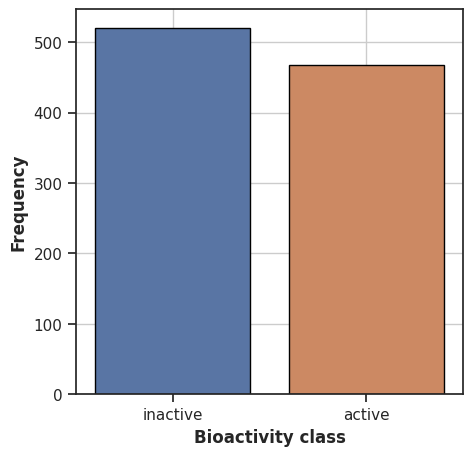

In [35]:
plt.figure(figsize=(5, 5))

sns.countplot(x="bioactivity_class", data=df, edgecolor="black")

plt.xlabel("Bioactivity class", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.grid(True)
plt.show()

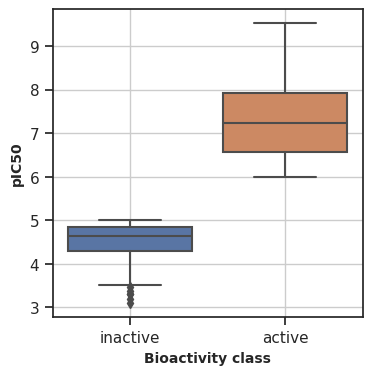

In [36]:
box_plot(df, x_axis="bioactivity_class", y_axis="pIC50", 
         x_label="Bioactivity class", y_label="pIC50")

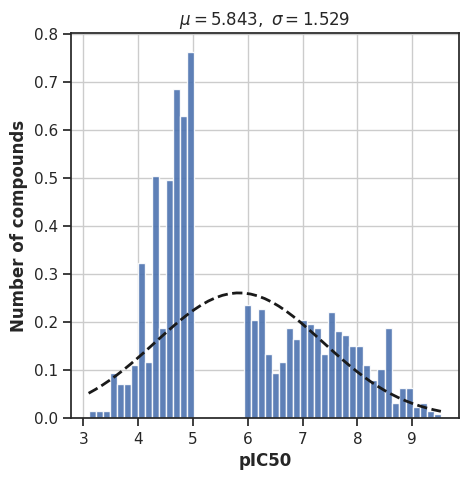

In [37]:
histogram_plot(df, x_axis="pIC50", x_label="pIC50")

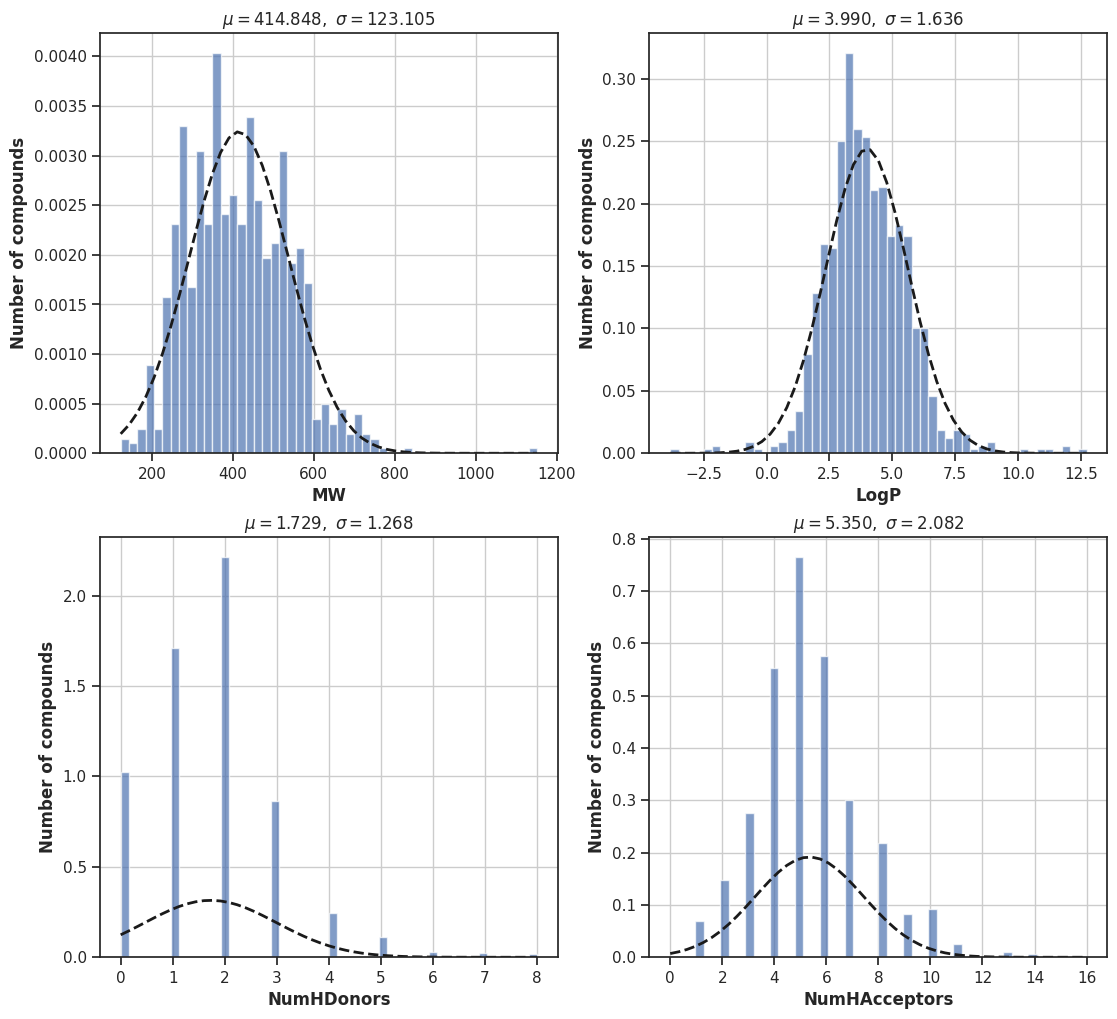

In [38]:
default_descriptors_histogram_plot(df)

<AxesSubplot: >

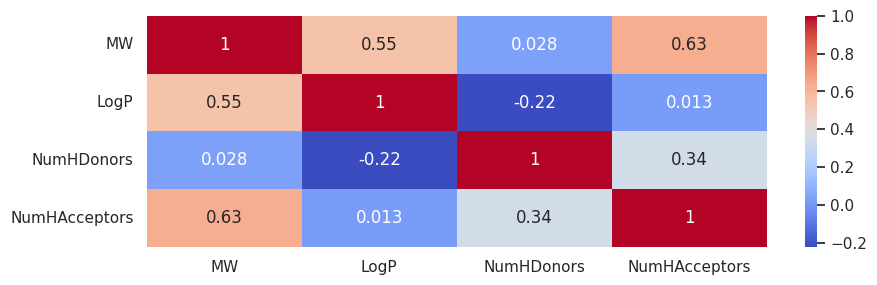

In [39]:
sns.set(rc = {"figure.figsize":(10, 3)})
sns.heatmap(df[DEFAULT_DESCRIPTORS].corr(), annot = True, fmt=".2g",cmap="coolwarm")

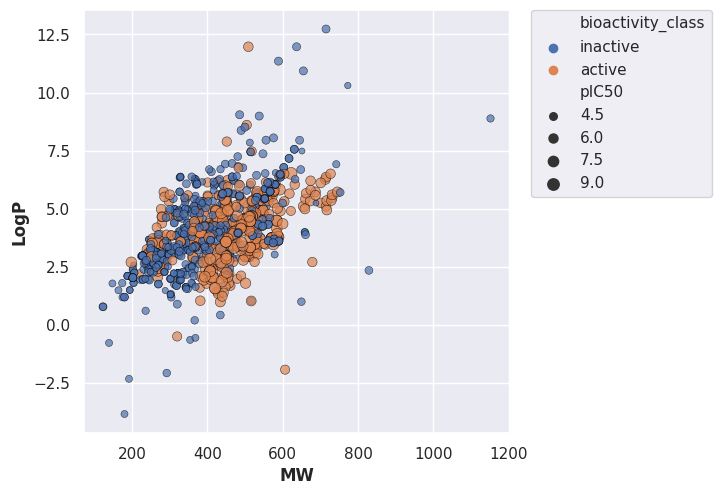

In [40]:
scatter_plot(df=df, x_axis="MW", y_axis="LogP", x_label="MW", y_label="LogP", 
                 hue="bioactivity_class", size="pIC50")

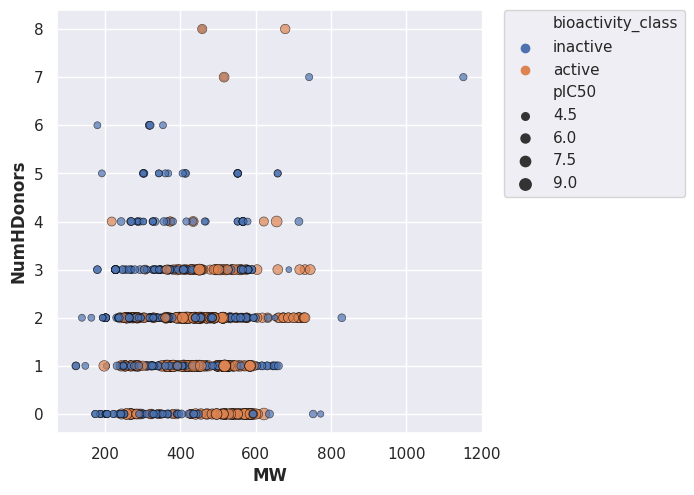

In [41]:
scatter_plot(df=df, x_axis="MW", y_axis="NumHDonors", x_label="MW", y_label="NumHDonors", 
                 hue="bioactivity_class", size="pIC50")

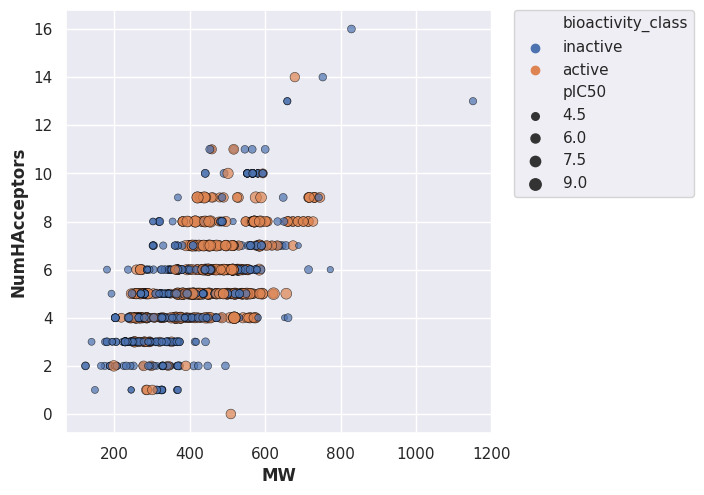

In [42]:
scatter_plot(df=df, x_axis="MW", y_axis="NumHAcceptors", x_label="MW", y_label="NumHAcceptors", 
                 hue="bioactivity_class", size="pIC50")

## 3.2 Mann-Whitney U test

The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions.

In [43]:
def mannwhitney_u_test(df: pd.DataFrame, descriptor: str) -> pd.DataFrame:
    seed(SEED)

    active = df[df.bioactivity_class == "active"][descriptor]
    inactive = df[df.bioactivity_class == "inactive"][descriptor]

    statistic, p_value = mannwhitneyu(active, inactive)

    alpha = 0.05
    if p_value > alpha:
        interpretation = "Same distribution (fail to reject H0)"
    else:
        interpretation = "Different distribution (reject H0)"

    return pd.DataFrame.from_dict({"Descriptor": [descriptor],
                                   "Statistics": [statistic],
                                   "P-value": [p_value],
                                   "α": [alpha],
                                   "Interpretation": [interpretation]})

In [44]:
mannwhitney_dict = dict()

for descriptor in MANN_WHITNEY_DESCRIPTORS:
    descriptor_result = mannwhitney_u_test(df, descriptor)
    mannwhitney_dict.update({descriptor: descriptor_result})
    
len(mannwhitney_dict)

5

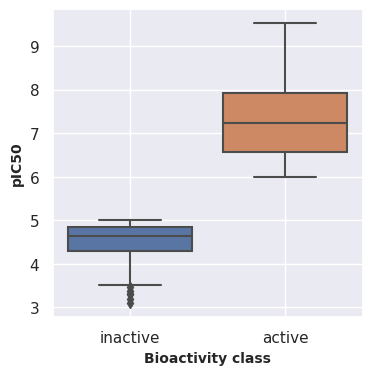

,Descriptor,Statistics,P-value,α,Interpretation
0,pIC50,243828.00,0.00,0.05,Different distribution (reject H0)


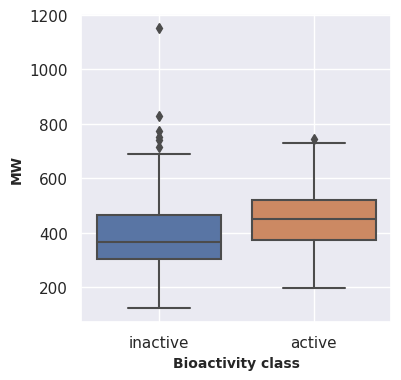

,Descriptor,Statistics,P-value,α,Interpretation
0,MW,160410.50,0.00,0.05,Different distribution (reject H0)


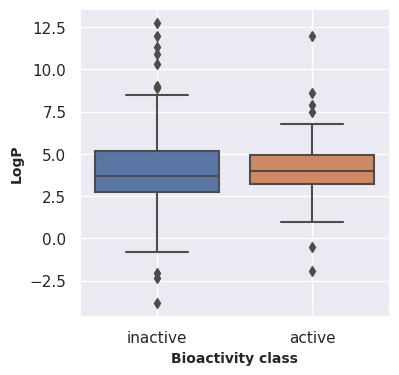

,Descriptor,Statistics,P-value,α,Interpretation
0,LogP,131079.50,0.04,0.05,Different distribution (reject H0)


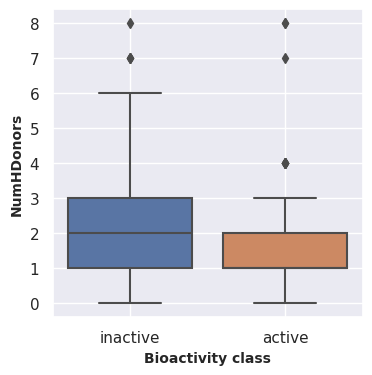

,Descriptor,Statistics,P-value,α,Interpretation
0,NumHDonors,93084.50,0.00,0.05,Different distribution (reject H0)


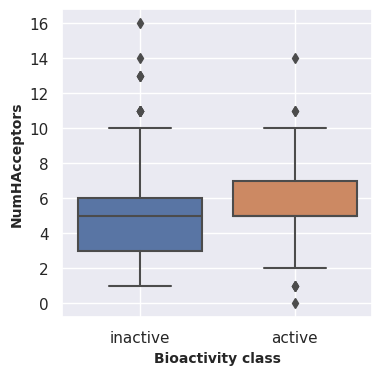

,Descriptor,Statistics,P-value,α,Interpretation
0,NumHAcceptors,154265.50,0.00,0.05,Different distribution (reject H0)


In [45]:
for descriptor in MANN_WHITNEY_DESCRIPTORS:
    print("\n")
    box_plot(df, x_axis="bioactivity_class", y_axis=descriptor, 
         x_label="Bioactivity class", y_label=descriptor)
    display(mannwhitney_dict[descriptor])
    print("\n")

Active and inactive distributions for pIC50 descriptor are **statistically different**. This is to be expected since we used threshold values (1,000 and 10,000) to separate two classes. \
All 4 Lipinski's descriptors shows **statistically significant difference** between actives and inactives.

## 4. Calculate Molecular Fingerprints

PaDEL-Descriptor is used for calculating molecular fingerprints

In [46]:
fingerprints_input_file = "input_smiles.smi"
fingerprints_output_file = "molecular_fingerprints.csv"

In [47]:
smiles_df = df_full[["canonical_smiles", "activity_id"]]

In [48]:
print(smiles_df.shape)
smiles_df.head(3)

(1391, 2)


,canonical_smiles,activity_id
0,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,357577
1,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,357580
2,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,358965


In [49]:
smiles_df.to_csv(fingerprints_input_file, sep="\t", index=False, header=False)

In [50]:
padeldescriptor(mol_dir=fingerprints_input_file, 
                d_file=fingerprints_output_file,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [51]:
fingerprints_df = pd.read_csv(fingerprints_output_file)

In [52]:
print(fingerprints_df.shape)
fingerprints_df.head(3)

(1391, 882)


,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,357577,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,357580,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,358965,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
fingerprints_df = fingerprints_df.rename(columns={"Name": "activity_id"})
fingerprints_df.head(1)

,activity_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,357577,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# merge fingerprints data and data from df dataset
descriptors_df = fingerprints_df.merge(df_full, how="outer", on="activity_id")
print(descriptors_df.shape)
descriptors_df.head(5)

(1391, 890)


,activity_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP879,PubchemFP880,molecule_chembl_id,canonical_smiles,bioactivity_class,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,357577,1,1,1,0,0,0,0,0,0,...,0,0,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,intermediate,5.30,311.42,3.32,1,2
1,357580,1,1,1,0,0,0,0,0,0,...,0,0,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,intermediate,5.57,299.46,3.24,1,3
2,358965,1,1,1,0,0,0,0,0,0,...,0,0,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,intermediate,5.74,311.42,3.32,1,2
3,368887,1,1,1,0,0,0,0,0,0,...,0,0,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,inactive,4.96,327.88,3.83,1,2
4,375954,1,1,1,0,0,0,0,0,0,...,0,0,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,inactive,5.00,372.33,3.94,1,2


In [55]:
descriptors_df.to_csv("descriptors_df.csv", index=False)

## 5. Applying ML Algorithms for Bioactivity Prediction

### 5.1 Dataset preparation

In [56]:
fingerprints_names = fingerprints_df.columns.tolist()
fingerprints_names.remove("activity_id")

X = descriptors_df[fingerprints_names]
print(X.shape)
X.head(3)

(1391, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# remove low variance features
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
X.shape

(1391, 168)

In [58]:
Y = descriptors_df["pIC50"]
Y.shape

(1391,)

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1112, 168) (1112,)
(279, 168) (279,)


### 5.2 Random Forest for Bioactivity Prediction

In [60]:
seed(SEED)
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, Y_train)

RandomForestRegressor()

In [61]:
r2_train = rf_model.score(X_train, Y_train)
r2_train

0.9379178615972668

In [62]:
r2_test = rf_model.score(X_test, Y_test)
r2_test

0.7723116990946666

In [63]:
Y_pred_train = rf_model.predict(X_train)
Y_pred_test = rf_model.predict(X_test)

In [65]:
def plot_train_test_comparison(y_train: np.array, y_test: np.array, y_pred_train: np.array, y_pred_test: np.array):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].scatter(x=y_train, y=y_pred_train, alpha=0.2)

    z = np.polyfit(y_train, y_pred_train, 1)
    p = np.poly1d(z)
    axs[0].plot(y_train, p(y_train), "k", linewidth=1)

    axs[0].set_title("True vs Predicted for Train Set", fontsize=12)
    axs[0].set_xlabel("True pIC50", fontsize=12, fontweight="bold")
    axs[0].set_ylabel("Predicted pIC50", fontsize=12, fontweight="bold")

    axs[1].scatter(x=y_test, y=y_pred_test, alpha=0.5)

    z = np.polyfit(y_test, y_pred_test, 1)
    p = np.poly1d(z)
    axs[1].plot(y_test, p(y_test), "k", linewidth=1)

    axs[1].set_title("True vs Predicted for Test Set", fontsize=12)
    axs[1].set_xlabel("True pIC50", fontsize=12, fontweight="bold")
    axs[1].set_ylabel("Predicted pIC50", fontsize=12, fontweight="bold")
    plt.show()

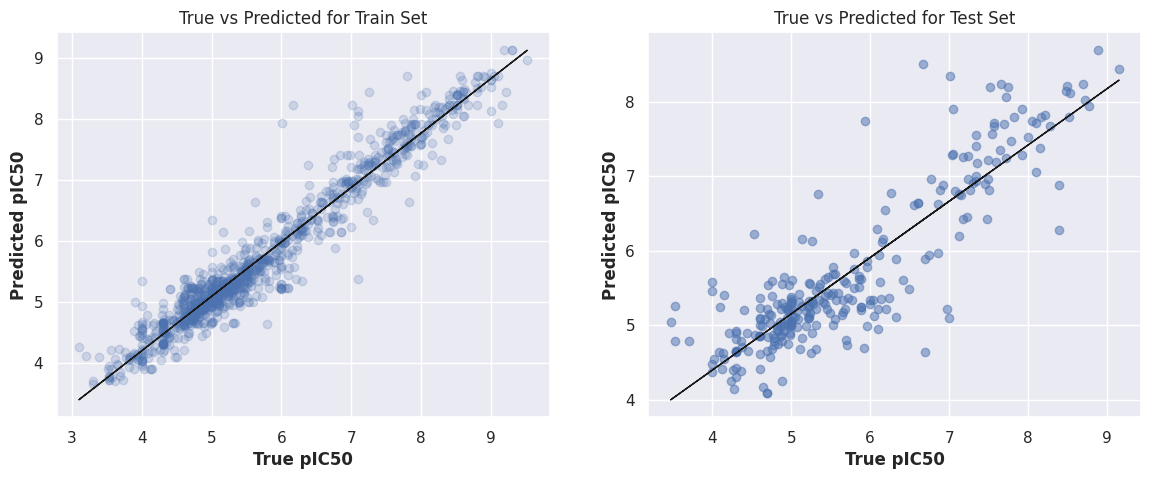

In [66]:
plot_train_test_comparison(Y_train, Y_test, Y_pred_train, Y_pred_test)

### 5.3 Try Different ML Algorithms for Bioactivity Prediction

In [67]:
reg = LazyRegressor(predictions=True)

In [68]:
clf = LazyRegressor()
models_train, predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 41/42 [02:18<00:02,  2.42s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 504
[LightGBM] [Info] Number of data points in the train set: 1112, number of used features: 168
[LightGBM] [Info] Start training from score 5.713517


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [02:18<00:00,  3.30s/it]


In [69]:
# Performance table of the training set (80% subset)
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GaussianProcessRegressor,0.95,0.96,0.27,0.64
DecisionTreeRegressor,0.95,0.96,0.27,0.12
ExtraTreeRegressor,0.95,0.96,0.27,0.12
ExtraTreesRegressor,0.95,0.96,0.27,1.92
XGBRegressor,0.95,0.96,0.27,0.57
RandomForestRegressor,0.93,0.94,0.33,1.82
MLPRegressor,0.92,0.94,0.34,2.78
BaggingRegressor,0.92,0.93,0.35,0.24
HistGradientBoostingRegressor,0.90,0.92,0.38,1.58


In [70]:
clf = LazyRegressor()
models_test, predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [01:27<00:00,  2.08s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 504
[LightGBM] [Info] Number of data points in the train set: 1112, number of used features: 168
[LightGBM] [Info] Start training from score 5.713517


In [71]:
# Performance table of the test set (20% subset)
predictions_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.43,0.77,0.60,1.48
LGBMRegressor,0.42,0.77,0.60,0.20
HistGradientBoostingRegressor,0.41,0.77,0.61,5.03
KNeighborsRegressor,0.40,0.76,0.61,0.14
SVR,0.40,0.76,0.61,0.26
NuSVR,0.39,0.76,0.62,0.37
BaggingRegressor,0.39,0.76,0.62,0.17
XGBRegressor,0.31,0.73,0.66,0.26
MLPRegressor,0.30,0.72,0.66,3.63


[(0.0, 1.0)]

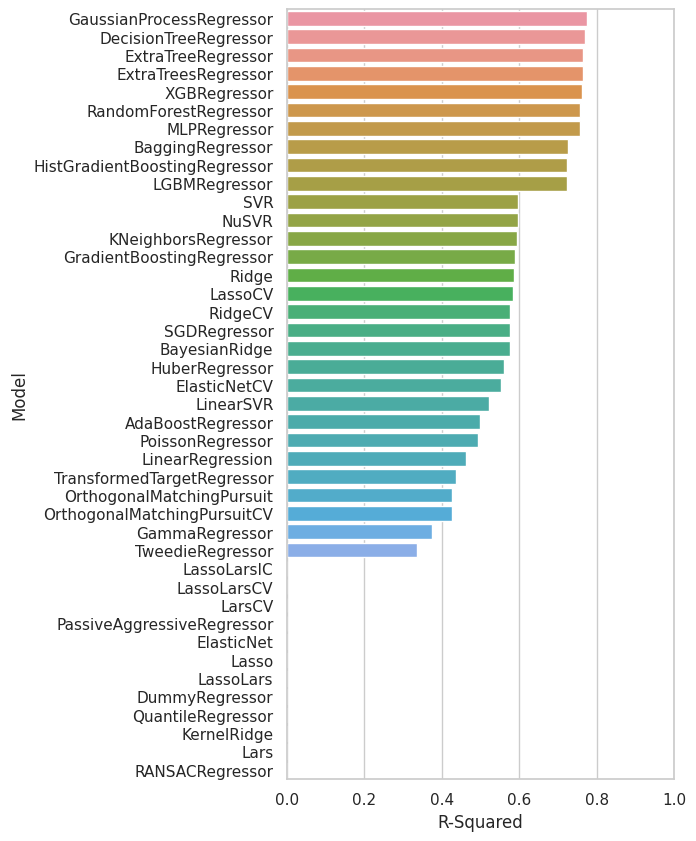

In [74]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_test)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

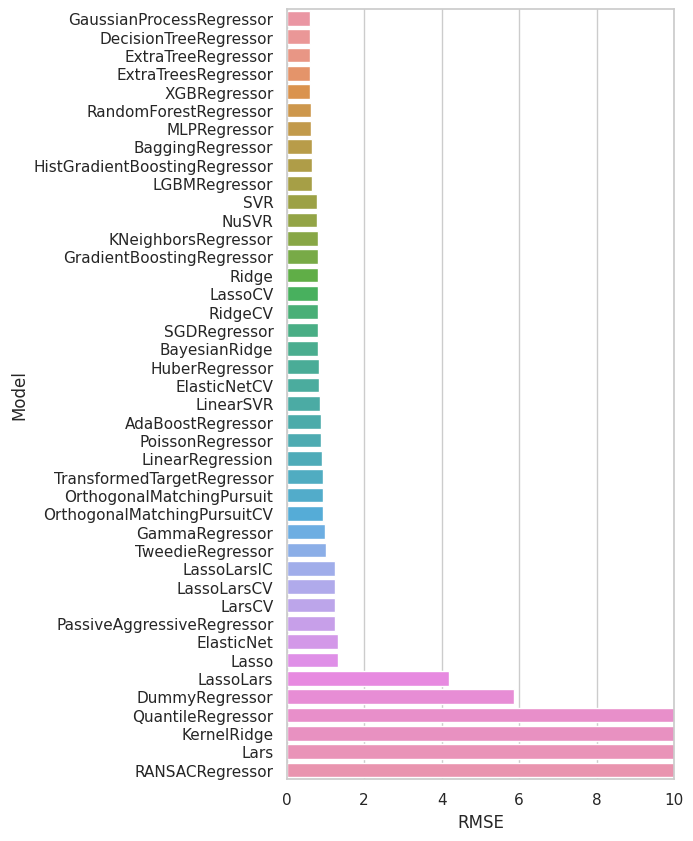

In [75]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_test)
ax.set(xlim=(0, 10))